# MODEL OPTIMIZATION

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

## LOAD MODEL SCORES

In [2]:
with open('pickles/model_optimization_train_scores.plk','rb') as f:
    train_pickle = pickle.load(f)
with open('pickles/model_optimization_test_scores.plk','rb') as f:
    test_pickle = pickle.load(f)

## LINEAR REGRESSION

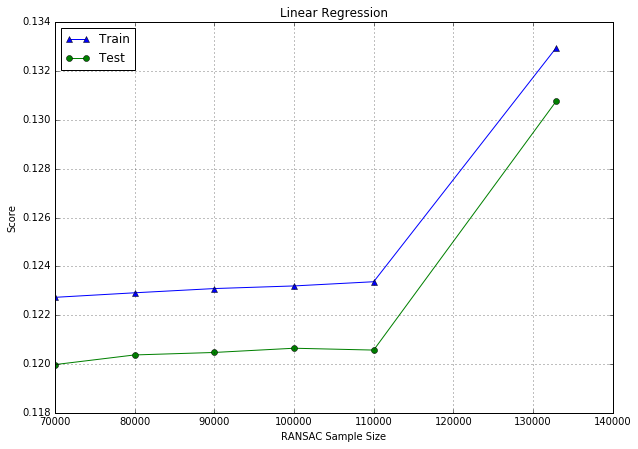

In [3]:
name = 'Linear'
param_list = train_pickle[name][0]
train_scores= train_pickle[name][1]
test_scores = test_pickle[name][1]
plt.figure(figsize=(10,7))
plt.plot(param_list,train_scores,marker='^')
plt.plot(param_list,test_scores,marker='o')
plt.legend(['Train','Test'],loc=0)
plt.title('Linear Regression')
plt.xlabel('RANSAC Sample Size')
plt.ylabel('Score')
plt.grid(True)
plt.show()

## RANDOM FOREST

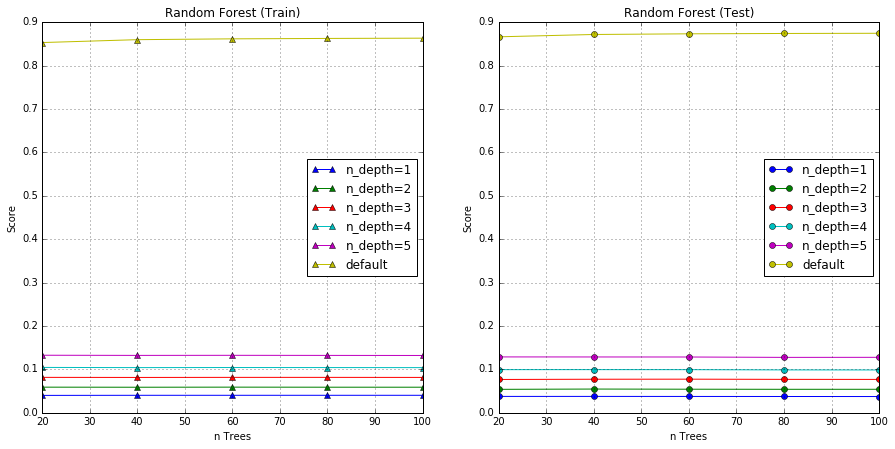

In [4]:
name = 'Random Forest'
param_list = train_pickle[name][0]
train_scores= train_pickle[name][1]
test_scores = test_pickle[name][1]
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = axs[0]
ax.plot(param_list,train_scores,marker='^')
ax.legend(['n_depth={}'.format(n) for n in range(1,6)]+['default'],loc=5)
ax.legend()
ax.set_title('Random Forest (Train)')
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)
ax = axs[1]
ax.plot(param_list,test_scores,marker='o')
ax.legend(['n_depth={}'.format(n) for n in range(1,6)]+['default'],loc=5)
ax.set_title('Random Forest (Test)')
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

## Gradient Boosting

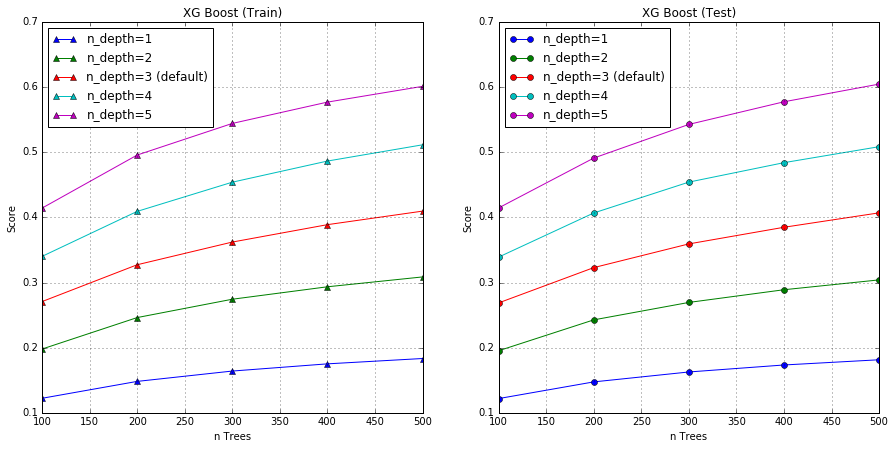

In [5]:
name = 'Gradient Boost'
param_list = train_pickle[name][0]
train_scores= train_pickle[name][1]
test_scores = test_pickle[name][1]
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = axs[0]
ax.plot(param_list,train_scores,marker='^')
ax.legend(['n_depth={} (default)'.format(n) if n==3 else 'n_depth={}'.format(n) for n in range(1,6)]+['default'],loc=2)
ax.set_title('XG Boost (Train)')
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)
ax = axs[1]
ax.plot(param_list,test_scores,marker='o')
ax.legend(['n_depth={} (default)'.format(n) if n==3 else 'n_depth={}'.format(n) for n in range(1,6)]+['default'],loc=2)
ax.set_title('XG Boost (Test)')
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

## PICKLE MODELS

In [6]:
df = pd.read_csv('data/wheat-2013-supervised-edited.csv')
drop_cols = ['Latitude','Longitude'] + [df.columns[0]]
df.drop(drop_cols,axis=1,inplace=True)

In [7]:
with open('pickles/SBS_feat_set.plk','rb') as f:
    sbs_dict = pickle.load(f)

In [8]:
models = {}
models['Linear'] = LinearRegression()
models['Random Forest'] = RandomForestRegressor(random_state=42)
models['Gradient Boost'] = GradientBoostingRegressor(n_estimators=500,max_depth=5)

In [9]:
for name,model in models.items():
    if name == 'Random Forest':
        k = 4
        X = np.matrix(df.ix[:,:-1])[:,list(sbs_dict[name][k])]
        y = np.array(df.ix[:,-1])
        X_train, X_test, y_train, y_test = train_test_split(X,ytest_size=0.25,random_state=42)
    elif name == 'Linear':
        k = 8
        X = np.matrix(df.ix[:,:-1])[:,list(sbs_dict[name][k])]
        y = np.array(df.ix[:,-1])
        X_std = StandardScaler().fit_transform(X)
        y_std = StandardScaler().fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X_std,y_std,test_size=0.25,random_state=42)
    elif name == 'Gradient Boost':
        X = np.matrix(df.ix[:,:-1])[:,list(sbs_dict[name][k])]
        y = np.array(df.ix[:,-1])
        X_train, X_test, y_train, y_test = train_test_split(X,ytest_size=0.25,random_state=42)
    trained_model = model.fit(X_train,y_train)
    
    with open('pickles/trained_model2_{}.plk'.format(name),'wb') as f:
        pickle.dump(trained_model,f)

## References

https://www.researchgate.net/post/How_to_determine_the_number_of_trees_to_be_generated_in_Random_Forest_algorithm